In [88]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

In [89]:
using LinearAlgebra
# using PyPlot
using Plots
using ForwardDiff
using RobotZoo
using RobotDynamics
using Ipopt
using MathOptInterface
using StaticArrays
using SparseArrays
# Pkg.add("MATLAB")
using MATLAB 
# Pkg.add("DataStructures")
include("Non_lin_exp.jl")
include("CR3BP_Dynamics.jl")
include("sparseblocks.jl")
const MOI = MathOptInterface;

In [119]:
Nx = 6     # number of state
Nu = 1     # number of controls
Tfinal = pi # final time-50 knot points or something similar 
Nt = 50   # number of time steps-52
h = Tfinal/(Nt-1) 
thist = Array(range(0,Tfinal, step=h));#0:pi,step: 0.06 
n_nlp = (Nx+Nu)*Nt # number of decision variables-350
m_nlp = Nx*(Nt+1) #306
u_idx = [(Nx+Nu)*(i-1) .+ (Nx+1:Nx+Nu) for i = 1:Nt];
x_idx = [(Nx+Nu)*(i-1) .+ (1:Nx) for i = 1:Nt];
@show h

0.0641141357875468

In [120]:
include("Non_lin_exp.jl")
#Calc of Reference Trajectory 
Xref =[zeros(Nx) for i=1:Nt];
for k = 1:Nt
    Pos = Non_lin_exp(thist[k]);
    # Pos = lin_approx(thist[k]);
    Xref[k][1] = Pos[1];
    Xref[k][2] = Pos[2];
    Xref[k][3] = Pos[3];
    Vels = ForwardDiff.derivative(Non_lin_exp,thist[k]);
    # Vels = ForwardDiff.derivative(lin_approx,thist[k]);
    Xref[k][4] = Vels[1];
    Xref[k][5] = Vels[2];
    Xref[k][6] = Vels[3];
end
Uref = h*ones(Nt);

In [121]:
xRef = zeros(Nt)
yRef = zeros(Nt)
zRef = zeros(Nt)

for k = 1:Nt
    xRef[k] = Xref[k][1]
    yRef[k] = Xref[k][2]
    zRef[k] = Xref[k][3]
end

# Plots.plot(xRef,yRef)

In [122]:
function dircol_dynamics(x1,x2,h)
    #Hermite-Simpson integration with first-order hold on u
    f1 = CR3BPdynamics(x1) #Timestep k
    f2 = CR3BPdynamics(x2) #Timestep k+1
    xm = 0.5.*(x1 + x2) .+ (h/8.0).*(f1 - f2) #
    ẋm = (-3.0/(2.0*h)).*(x1 - x2) .- 0.25.*(f1 + f2)
    fm = CR3BPdynamics(xm)
    return fm - ẋm
end

dircol_dynamics (generic function with 1 method)

In [123]:
# Cost weights
Q = Diagonal([0.95*10e8*ones(3); 0.95*10e8*ones(3)]);
R = 0.001;

In [124]:
function stage_cost(x,u,Xref,Uref)
    return 0.5*((x.-Xref)'*Q*(x.-Xref)) + 0.5*(u.-Uref)'*R*(u.-Uref)
end

stage_cost (generic function with 1 method)

In [125]:
function cost(ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)
    J = 0.0
    for k = 1:Nt
        J += stage_cost(z[1:Nx,k],z[(Nx+1):(Nx+Nu),k],Xref[k],Uref[k])
    end
    return J
end

cost (generic function with 1 method)

In [126]:
function dynamics_constraint!(c,ztraj)
    d = reshape(c,Nx,Nt) # c[6,50] = 300
    z = reshape(ztraj,Nx+Nu,Nt) #ztraj[7,50]
    for k = 1:(Nt-1)
        x1 = z[1:Nx,k]
        u1 = z[(Nx+1):(Nx+Nu),k]
        x2 = z[1:Nx,k+1]
        d[:,k] = dircol_dynamics(x1,x2,u1)
    end
    return nothing
end

dynamics_constraint! (generic function with 1 method)

In [127]:
function con!(c,ztraj)
    z = reshape(ztraj,Nx+Nu,Nt)#7 x 50
    @views dynamics_constraint!(c[1:(end-Nx)],ztraj) #6 x 50 
    #Periodicity Constraint 
    c[(end-Nx+1):end] .= z[1:Nx,end] - z[1:Nx,1]
end

con! (generic function with 1 method)

In [133]:
struct ProblemMOI <: MOI.AbstractNLPEvaluator
    n_nlp::Int
    m_nlp::Int
    idx_ineq
    obj_grad::Bool
    con_jac::Bool
    sparsity_jac
    sparsity_hess
    primal_bounds
    constraint_bounds
    hessian_lagrangian::Bool
    blocks::BlockViews

    function ProblemMOI(n_nlp,m_nlp;
        idx_ineq=(1:0),
        obj_grad=true,
        con_jac=true,
        sparsity_jac=sparsity_jacobian(n_nlp,m_nlp),
        sparsity_hess=sparsity_hessian(n_nlp,m_nlp),
        primal_bounds=primal_bounds(n_nlp),
        constraint_bounds=constraint_bounds(m_nlp,idx_ineq=idx_ineq),
        hessian_lagrangian=false,
        blocks= BlockViews(m_nlp,n_nlp))

        ProblemMOI(n_nlp,m_nlp,
            idx_ineq,
            obj_grad,
            con_jac,
            sparsity_jac,
            sparsity_hess,
            primal_bounds,
            constraint_bounds,
            hessian_lagrangian,
            blocks)
    end
end 
#Our code 
function primal_bounds(n)
    x_l = -Inf*ones(n)
    x_u = Inf*ones(n) #+_ 20% dt_ref
    for k = 1:Nt
        x_l[u_idx[k]] .= h*0.01 #Something reasonable based on dt_ref 0.8*dt
        x_u[u_idx[k]] .= h*1.5
    end 

    return x_l, x_u
end

#Our code 
function constraint_bounds(m; idx_ineq=(1:0))
    c_l = zeros(m)
    c_u = zeros(m)
    return c_l, c_u
end
#Our code 

function row_col!(row,col,r,c)
    for cc in c
        for rr in r
            push!(row,convert(Int,rr))
            push!(col,convert(Int,cc))
        end
    end
    return row, col
end
####################-SPARSITY-####################
function initialize_sparsity!(prob)
    # n,m = Nx, Nu
    n = 0 
    blocks = prob.blocks
    idx = x_idx[1]
    for k = 1:Nt-1
        idx = idx .+ n
        setblock!(blocks, idx, x_idx[k])
        setblock!(blocks, idx, u_idx[k])
        setblock!(blocks, idx, x_idx[k+1])
        n = Nx
    end
#Periodicity Constraint
    idx = idx .+ n 
    for i = 1:n
        setblock!(blocks, idx[i], x_idx[1][i])
        setblock!(blocks, idx[i], x_idx[end][i])
    end
end
####################-SPARSITY-####################

function sparsity_jacobian(n,m)
#######-Dense Jac-###############
    row = []
    col = []
    r = 1:m
    c = 1:n
    row_col!(row,col,r,c)
    # return collect(zip(row,col))
#######-Sparse Jac-###############
    rc = Tuple{Int,Int}[]
    # SOLUTION
    initialize_sparsity!(prob)
    rc = getrc(prob.blocks)
    return rc 
end 

function sparsity_hessian(n,m)

    row = []
    col = []

    r = 1:m
    c = 1:n

    row_col!(row,col,r,c)

    return collect(zip(row,col))
end

function MOI.eval_objective(prob::MOI.AbstractNLPEvaluator, x)
    cost(x)
end

function MOI.eval_objective_gradient(prob::MOI.AbstractNLPEvaluator, grad_f, x)
    ForwardDiff.gradient!(grad_f,cost,x)
    return nothing
end

function MOI.eval_constraint(prob::MOI.AbstractNLPEvaluator,g,x)
    con!(g,x)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::MOI.AbstractNLPEvaluator, jac, x)
    ForwardDiff.jacobian!(reshape(jac,prob.m_nlp,prob.n_nlp), con!, zeros(prob.m_nlp), x)
    return nothing
end

function MOI.features_available(prob::MOI.AbstractNLPEvaluator)
    return [:Grad, :Jac]
end

MOI.initialize(prob::MOI.AbstractNLPEvaluator, features) = nothing
MOI.jacobian_structure(prob::MOI.AbstractNLPEvaluator) = prob.sparsity_jac

function solve(x0,prob::MOI.AbstractNLPEvaluator;
        tol=1.0e-9,c_tol=1.0e-9,max_iter=10000)
    x_l, x_u = prob.primal_bounds
    c_l, c_u = prob.constraint_bounds

    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    block_data = MOI.NLPBlockData(nlp_bounds,prob,true)

    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol

    x = MOI.add_variables(solver,prob.n_nlp)

    for i = 1:prob.n_nlp
        x_idx = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, x_idx, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, x_idx, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res
end

ErrorException: invalid redefinition of constant ProblemMOI

In [132]:
#Guess
z0 = zeros((Nx+Nu)*(Nt))
# z0[x_idx[1]] = Xref[1]
for k=1:Nt
    z0[x_idx[k]] = Xref[k]
    z0[u_idx[k]] .= Uref[k]
end

In [101]:
# prob = ProblemMOI(n_nlp,m_nlp)
# z_sol = solve(z0,prob) # solve

In [102]:
ztraj = reshape(z_sol,Nx+Nu,Nt);
xtraj = ztraj[1:Nx,:];#6 x 91
utraj = ztraj[(Nx+1):(Nx+Nu),:]; # 1 x 91
@show utraj

1×50 Matrix{Float64}:
 0.000641209  0.0961052  0.000641141  …  0.000641191  0.0961694  0.0500236

In [103]:
xtraj
# p = Plots.plot(xRef,yRef)
# Plots.plot!(p,xtraj[1,:],xtraj[2,:])
# Plots.plot(xtraj[1,:],xtraj[2,:])
# Plot(thist,xtraj[2,:])
# Plot(thist,xguess[1,:])
# PyPlot.show()

6×50 Matrix{Float64}:
  0.0377012  -0.0333978  -0.0155291   …  -0.0319126   0.00199253   0.0410273
  0.0296804  -0.0329849   0.00033258     -0.0124611   0.0381992   -0.0257134
 -0.0102443   0.0117892  -0.00687135     -0.0224402   0.0159445    0.0188508
 -3.0081     -3.07048    -3.3151         -2.27615    -3.31506     -3.00598
 -2.80842     4.19265     4.29084        -2.96825    -2.50192     -2.80722
  2.35093     1.01226     1.04889     …   1.85942     2.5878       2.34901

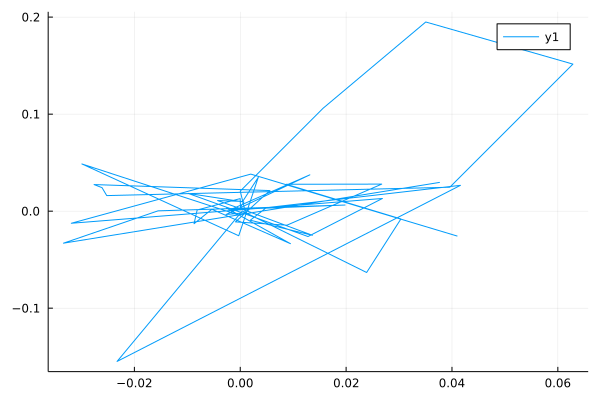

In [104]:
Plots.plot(xtraj[1,:],xtraj[2,:])
# Plots.plot(thist,xtraj[3,:])
# PyPlot.show()

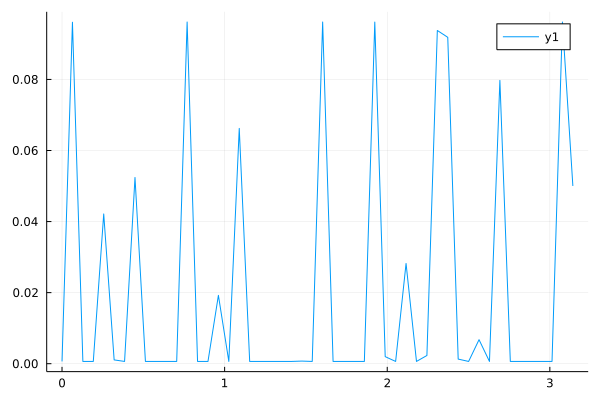

In [105]:
Plots.plot(thist,utraj[1,:])

In [106]:
xTraj = zeros(Nt)
yTraj = zeros(Nt)
zTraj = zeros(Nt)

for k = 1:Nt
    xTraj[k] = xtraj[1,k]
    yTraj[k] = xtraj[2,k]
    zTraj[k] = xtraj[3,k]
end


In [107]:
mat"""
plot3($xTraj,$yTraj,$zTraj,'DisplayName','IPOPT')
hold on 
plot3($xRef,$yRef,$zRef,'DisplayName','Reference')

legend('IPOPT','Reference')
""" 

In [108]:
mat"""
plot($xTraj,$yTraj,'DisplayName','IPOPT')
hold on 
plot($xRef,$yRef,'DisplayName','Reference')

legend('IPOPT','Reference')
""" 

In [136]:
let
    z_test = randn(n_nlp)
    c = randn(m_nlp)
    # jac = randn(m_nlp,n_nlp)
    jac = ForwardDiff.jacobian(con!,c,z_test)
    # con!(c,z_test)
    @show jac[x_idx[1],u_idx[1]]
    X_ = [zeros(Nx) for k = 1:Nt]
    X_[1] = Xref[1]
    for i = 1:Nt-1
        X_[i+1] = rk4(CR3BPdynamics,X_[i],h)
    end 
    A = [zeros(Nx,Nx) for k = 1:Nt]
    for i = 1:Nt 
        A[i] = ForwardDiff.jacobian(x->rk4(CR3BPdynamics,x,h),X_[i])
    end
    # n = 0 
    # for k = 1:Nt-1
    #     idx = idx .+ n
    #     x1,x2 = Z[xi[k]], Z[xi[k+1]]
    #     u1,u2 = Z[ui[k]], Z[ui[k+1]]
    #     t = nlp.times[k]
    #     h = nlp.times[k+1] - nlp.times[k]
        
    #     jac_x1 = view(jac, idx, xi[k])
    #     jac_u1 = view(jac, idx, ui[k])
    #     jac_x2 = view(jac, idx, xi[k+1])
    #     jac_u2 = view(jac, idx, ui[k+1])
        
    #     A1,B1 = nlp.A[k], nlp.B[k]
    #     A2,B2 = nlp.A[k+1], nlp.B[k+1]
    #     f1,f2 = nlp.f[k], nlp.f[k+1]
    #     xm,um = nlp.xm[k], nlp.um[k]
    #     Am,Bm = nlp.Am[k], nlp.Bm[k]
    #     Am1, Am2 = nlp.Am[k,2], nlp.Am[k,3]
    #     Bm1, Bm2 = nlp.Bm[k,2], nlp.Bm[k,3]
    #     dx1 = h/6 * (A1 + 4*Am*Am1) + I
    #     du1 = h/6 * (B1 + 4*(Am*Bm1 + Bm/2))
    #     dx2 = h/6 * (A2 + 4*Am*Am2) - I
    #     du2 = h/6 * (B2 + 4*(Am*Bm2 + Bm/2))
    #     jac_x1 .= dx1
    #     jac_u1 .= du1
    #     jac_x2 .= dx2
    #     jac_u2 .= du2

    #     n = Nx
    # end
end